In [3]:
# Cette ligne est exécutée pour ne pas répéter à chque fois plt.show()
%matplotlib inline
# import darts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.datasets import AirPassengersDataset

# 1. Building and manipulating timeseries

- Il existe plusieurs façons de la faire et parmis ces méthodes à partir de pandas `TimeSeries.from_dataframe()`
- Directement à partir de Numpy `TimeSeries.from_values()`
- À partir d'un fichier CSV `TimeSeries.from_csv()`
- À partir des données disponible dans la bibliothèque DARTS

## 1.1. Importer et créer une classe series

<Axes: xlabel='Month'>

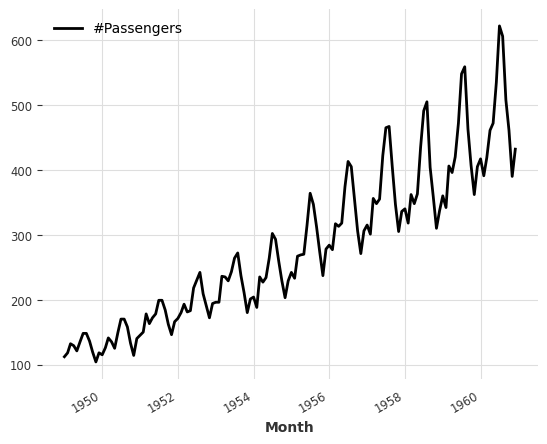

In [4]:
# Exemple 
series = AirPassengersDataset().load()
series.plot()

In [5]:
len(series)

144

## 1.2. Fractionner une Séries

<Axes: xlabel='Month'>

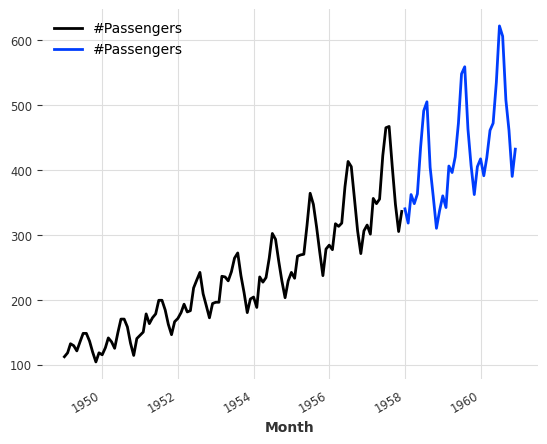

In [6]:
# Fractionnement en avant
series1, series2 = series.split_after(0.75)
series1.plot()
series2.plot()


## 1.3. Découper une séries

<Axes: xlabel='Month'>

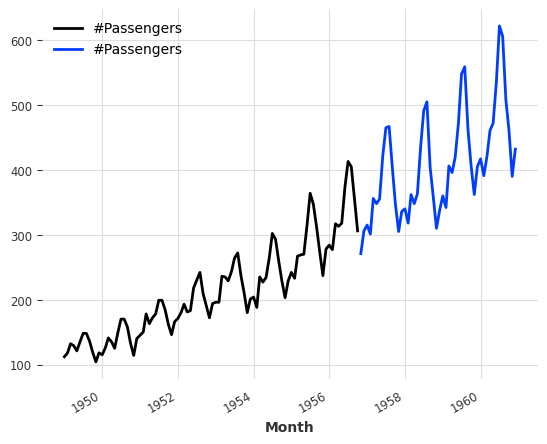

In [7]:
series1, series2 = series[:-50], series[-50:]
series1.plot()
series2.plot()

## 1.4. Opérations arithmétiques 

<Axes: xlabel='Month'>

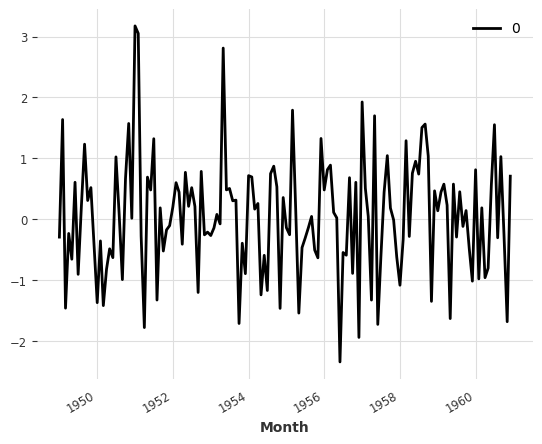

In [8]:
# Création d'un bruit(Création d'une séries à partir de valeurs)
series_noise = TimeSeries.from_times_and_values(
    series.time_index, np.random.randn(len(series))
)
series_noise.plot()

<Axes: xlabel='Month'>

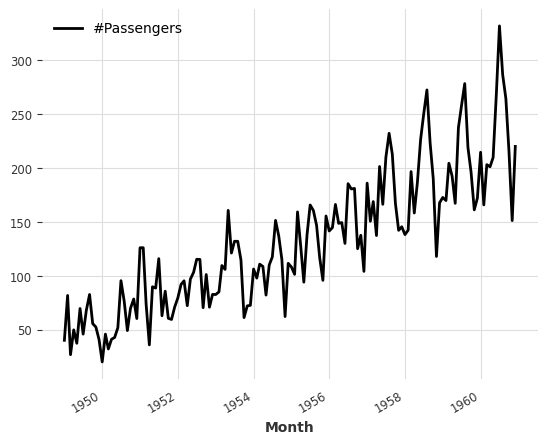

In [9]:
# Ajouter le bruit à la series
(series / 2 + 20 * series_noise - 10).plot()


## 1.5. Concaténation de séries

<Axes: xlabel='Month'>

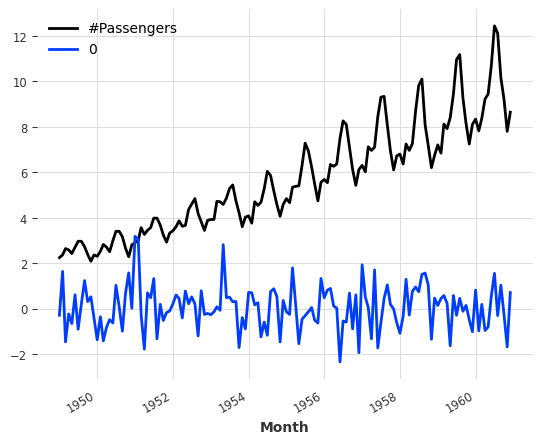

In [10]:
(series / 50).stack(series_noise).plot()


## 1.6. Mapping

<Axes: xlabel='Month'>

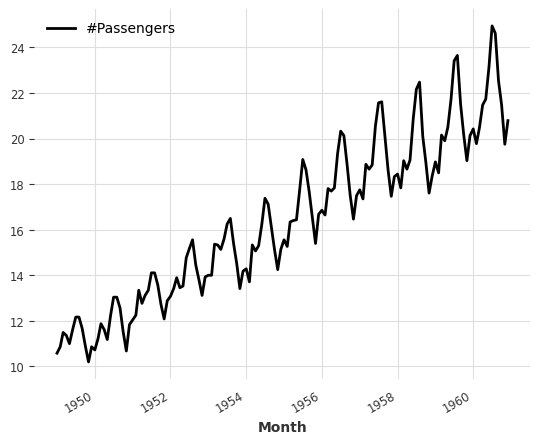

In [11]:
series.map(np.sqrt).plot()

## 1.7. Ajouter autres variables pour créer une séries chronologique multivariée

<Axes: xlabel='Month'>

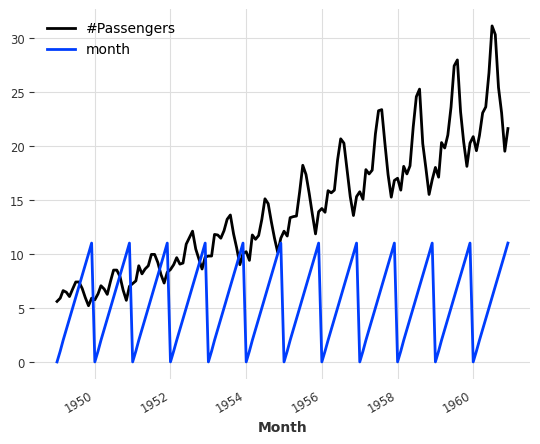

In [12]:
(series/20).add_datetime_attribute('month').plot()

## 1.8 Ajouter les jours fériés

<Axes: xlabel='Month'>

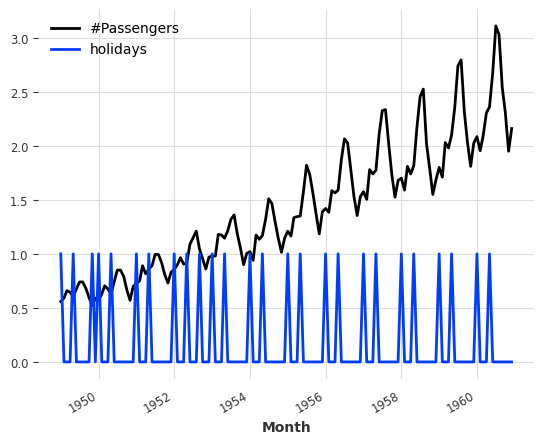

In [13]:
(series / 200).add_holidays("DZ").plot()


## 1.9. Remplir les valeurs manquantes 

<Axes: xlabel='time'>

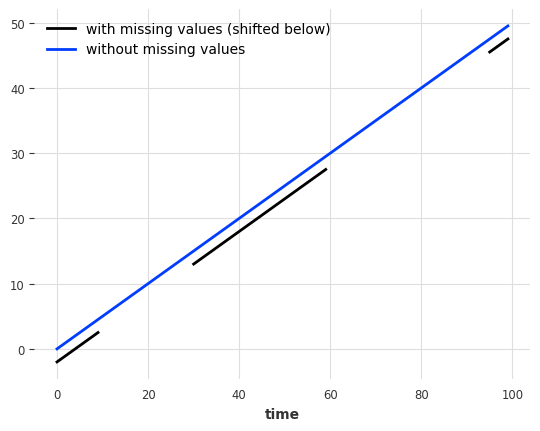

In [14]:
from darts.utils.missing_values import fill_missing_values

values = np.arange(50, step=0.5)
values[10:30] = np.nan
values[60:95] = np.nan
series_ = TimeSeries.from_values(values)

(series_ - 2).plot(label="with missing values (shifted below)")
fill_missing_values(series_).plot(label="without missing values")


## 1.10. Création d'ensembles d'etraînemet et de validation

<Axes: xlabel='Month'>

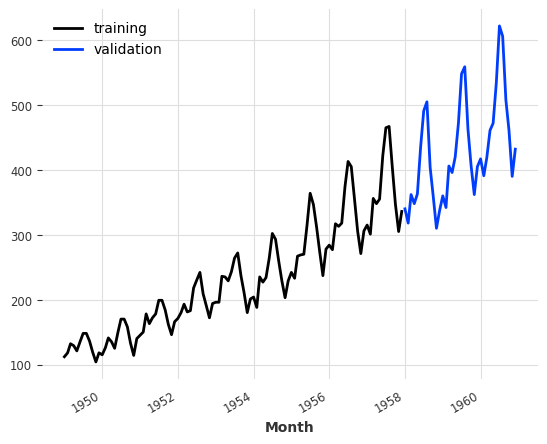

In [15]:
# Le split se fait cette fois-ci en se basant sur le temps et pas sur des indices numériques
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")

# 2.Entraînement des modèles et prédictions

Nous allons commencer par tester des modèles naïfs simple afin de comprendre le concept

## 2.1. Modèle naïf saisonal
Le modèle NaiveSeasonal est en effet un modèle simple pour la prévision de séries temporelles. Voici une correction et une explication plus précise du fonctionnement de ce modèle :

Modèle NaiveSeasonal
Définition de la saisonnalité :
Tout d’abord, vous devez définir la période de saisonnalité de votre série chronologique. Par exemple, si votre série est mensuelle, la saisonnalité serait de 12 (pour les 12 mois de l’année).
La saisonnalité représente la longueur du cycle récurrent dans vos données (par exemple, les variations saisonnières annuelles).
Entraînement du modèle :
Vous entraînez le modèle en utilisant les données historiques (série d’entraînement).
Le modèle stocke ces données pour les utiliser ultérieurement.
Prédiction des données futures :
Pour prédire les valeurs futures, le modèle utilise la valeur de la même période de l’année précédente.
Par exemple, si vous prédisez les ventes mensuelles pour le mois de juin, le modèle utilisera la valeur de juin de l’année précédente comme prédiction.
Répétition des dernières valeurs de la dernière saison :
Le modèle répète simplement les valeurs de la dernière saison pour prédire les valeurs futures.
Cela signifie que le modèle suppose que les variations saisonnières resteront constantes d’une année à l’autre.
En résumé, le modèle NaiveSeasonal est basé sur une hypothèse naïve : la saisonnalité reste constante et les valeurs futures sont identiques à celles de la même période de l’année précédente. Bien que simple, ce modèle peut être utile pour des séries avec une saisonnalité régulière, mais il ne tient pas compte d’autres facteurs tels que les tendances ou les variations imprévisibles .

<Axes: xlabel='Month'>

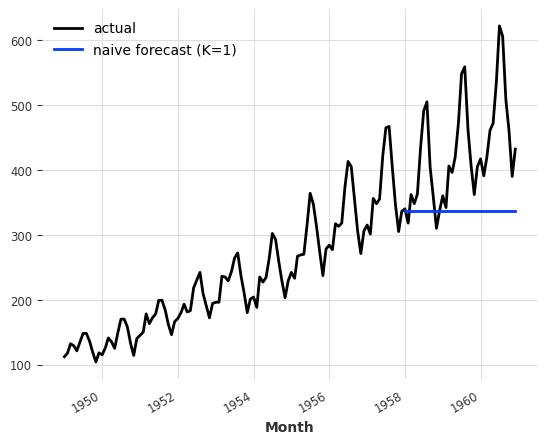

In [49]:
from darts.models import NaiveSeasonal

# 1. Initier le modèle
# k : Le nombre de saisonalités
naive_model = NaiveSeasonal(K=1)

# 2. Entraîner le modèle
naive_model.fit(train)

# 3. Prédire des données
# n : C'est le nombre de pas à prédire
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

# 2.2. Extraire la saisoalité
Comme la saisonalité est un hyperparamètre important, il est donc nécessaire de le chercher et de l'extraire
- Afin de chercher la saisonalité, nous calculons l'ACF pour voir où un pick est remarqué, le pick présente la saisonalité.
- L'intervalle de confiance ici est à 5%, les valeurs au-dessus de l'intervalle sont considéré vrais.

In [21]:
len(train)

108

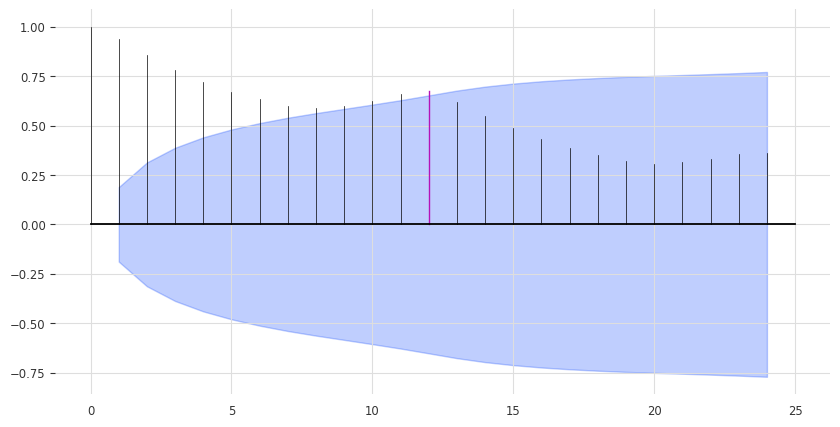

In [40]:
from darts.utils.statistics import plot_acf, check_seasonality
plot_acf(train, m=12, max_lag=24, alpha=0.05)
# train : La séries chronologique
# max_lag : Le nombre de décallage pour tester la corrélation
# alpha : l'intervale de confiance

In [47]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.051)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))


There is seasonality of order 12.


Maintenant que nous savons que la saisonalité et de 12 mois, nous pouvons modifier le modèle précédent

<Axes: xlabel='Month'>

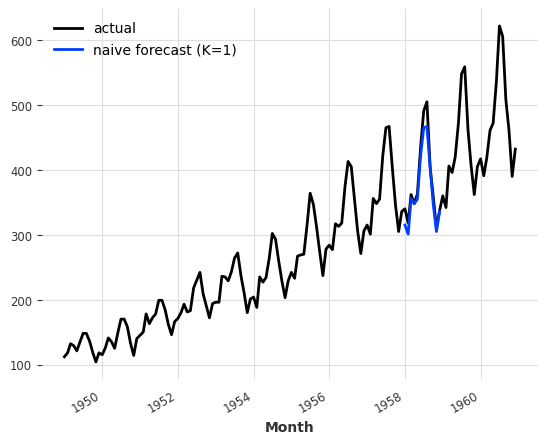

In [50]:
from darts.models import NaiveSeasonal

# 1. Initier le modèle
# k : Le nombre de saisonalités
naive_model = NaiveSeasonal(K=12)

# 2. Entraîner le modèle
naive_model.fit(train)

# 3. Prédire des données
# n : C'est le nombre de pas à prédire
naive_forecast = naive_model.predict(12)

# Tracer de toute le série
series.plot(label="actual")

# Tracer de la prédiction de la série
naive_forecast.plot(label="naive forecast (K=1)")